In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None, 'display.max_rows', 100) 

from os import path
import pickle

import sys
sys.path.append('..')
import src.functions.my_functions as my_func

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
7
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics.scorer import make_scorer

from sklearn.metrics import f1_score, recall_score, precision_score, fbeta_score

from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import SelectFromModel, SelectKBest, SelectPercentile, RFECV, RFE, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

from sklearn.tree import DecisionTreeClassifier

In [2]:
from imp import reload
reload(my_func)

<module 'src.functions.my_functions' from '..\\src\\functions\\my_functions.py'>

### Import

In [3]:
data = {}

ds = ['train', 'train_target', 'test', 'test_target']
d = ['..', 'data', 'processed']

for s in ds:    
    fn = 'loan_'+s+'.p'
    fp = path.join(*d, fn)

    with open(fp, 'rb') as file:
        data[s] = pickle.load(file)

In [4]:
data['train'].shape, data['train_target'].shape

((152218, 47), (152218, 2))

In [5]:
data['test'].shape, data['test_target'].shape

((38055, 47), (38055, 2))

### Data Preparation

In [6]:
# Columns identified thus far as best for classification (during data prep, select K best)
num_attr = ['funded_amnt_q10', 'int_rate_delta', 'annual_inc_q10', 'dti', 'delinq_2yrs', 'inq_last_6mths',
            'open_acc', 'revol_bal_log', 'revol_util', 'total_acc', 'collections_12_mths_ex_med',
            'acc_now_delinq', 'rev_lim_sqrt', 'tot_cur_bal', 'tot_coll_amt', 'subgrade_p_value',
            'lti', 'rbti', 'tbti', 'cr_line_td_log', 'emp_length_val']

bin_attr = ['had_delinq', 'had_major_derog', 'had_record', 'verified', 'term_bin']

cat_attr = ['purpose', 'home_ownership']

In [7]:
num_prep = Pipeline([('custom', my_func.CustomNumAttributes()), # Create custom num attr
                     ('select', my_func.DataFrame_Selector(num_attr)), # Select num columns
                     ('sc', StandardScaler())]) # Scale data

bin_prep = Pipeline([('custom', my_func.CustomBinAttributes()), # Create custom bin attr
                     ('select', my_func.DataFrame_Selector(bin_attr))]) # Select binary columns

cat_prep = Pipeline([('encode', my_func.DataFrame_DummyEncoder(cat_attr))]) # Select & encode categrocial columns

feature_prep = FeatureUnion([('num', num_prep),
                             ('bin', bin_prep),
                             ('cat', cat_prep)])

In [8]:
X_train_full = feature_prep.fit_transform(data['train'])

In [9]:
X_test = feature_prep.transform(data['test'])

In [10]:
X_train_full.shape, X_test.shape

((152218, 44), (38055, 44))

In [11]:
y_train_full = data['train_target']['default']
y_test = data['test_target']['default']

y_train_full.shape, y_test.shape

((152218,), (38055,))

In [12]:
def get_feature_prep_columns(feature_union):
    num_cols = feature_union.transformer_list[0][1].named_steps['select'].get_feature_names()
    bin_cols = feature_union.transformer_list[1][1].named_steps['select'].get_feature_names()
    cat_cols = feature_union.transformer_list[2][1].named_steps['encode'].get_feature_names()
    cols = num_cols + bin_cols + cat_cols
    return cols

In [13]:
feature_names = np.array(get_feature_prep_columns(feature_prep))
len(feature_names)

44

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

### Scoring

F2 scoring has been established as our best indicator for model performance. Recall is of higher priority due to the risks associated with failing to identify default loans versus falsely identifying healthy loans as default. Additionally, the proportion of non-default loans greatly outweights that of default, so even if we are only incorrectly identifying a small proportion of non-default loans this will have signficant effect on precision. Consequently, recall is weighed approx. twice as much as precision.

In [15]:
f2_score = make_scorer(fbeta_score, beta=2)

### Basic Model

In [164]:
lr_basic = LogisticRegression(class_weight='balanced')

In [165]:
my_func.run_time(reset=True)
lr_basic.fit(X_train, y_train)
my_func.run_time()

Time: 1.92s 


In [166]:
lr_basic_cvs = cross_val_score(lr_basic, X_train, y_train, scoring=f2_score)
my_func.print_cvs(lr_basic_cvs, 'f2')

Mean f2 score = 0.534 (+/- 0.005)


In [167]:
my_func.classifier_summary(y_train, lr_basic.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               64171               34143
Actual Positive                8167               15293
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.533690
Recall           0.651876
Precision (pos)  0.309349
Precision (neg)  0.887099
Specificity      0.652715


In [168]:
my_func.classifier_summary(y_val, lr_basic.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               16135                8495
Actual Positive                2021                3793
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.533564
Recall           0.652391
Precision (pos)  0.308675
Precision (neg)  0.888687
Specificity      0.655095


### Sample Size

We will see if there is any noteworthy change in model performance with various training sizes:

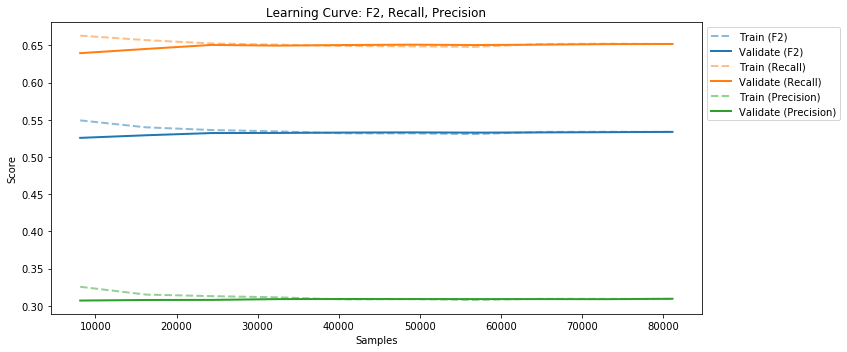

In [183]:
my_func.plot_learning_curve(lr_basic, X_train, y_train, scoring=['f2', 'recall', 'precision'], train_sizes=np.arange(0.1,1.1,0.1), n_jobs=4)

The learning curves seem to stabalize around 30,000 samples, after which they remain relatively constant. Based off these results there is little reason to tweak training sizes.

### Feature Selection

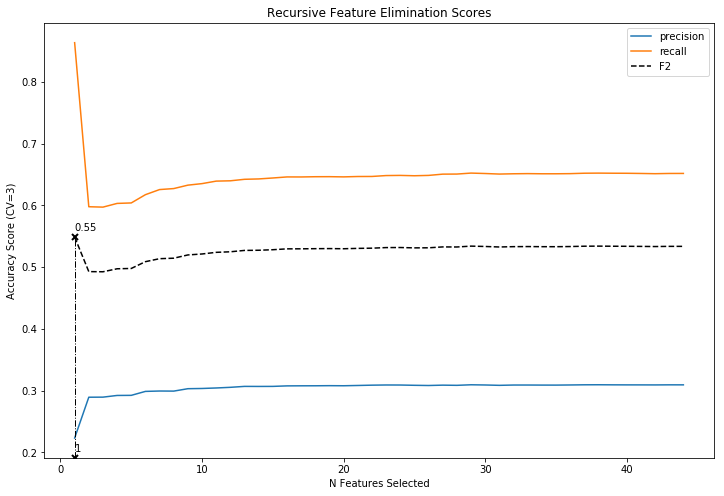

In [35]:
RFE_scores = my_func.plot_RFE(LogisticRegression(class_weight='balanced'), X_train, y_train, f_score=True, beta=2, n_jobs=4)

In [43]:
RFE_scores['recall'].n_features_

1

In [37]:
np.array(get_feature_prep_columns(feature_prep))[RFE_scores['recall'].get_support()]

array(['subgrade_p_value'],
      dtype='<U26')

In [38]:
print('Recall = {:.6f}'.format(RFE_scores['recall'].grid_scores_[0]))
print('Precision = {:.6f}'.format(RFE_scores['precision'].grid_scores_[0]))

Recall = 0.863555
Precision = 0.223353


Subgrade value on its own may yield the highest recall, but is comes at an unacceptable precision. Additionally, if we look at how these predictions work it becomes evident that all loans below a certain grade are simply dismissed as default loans. This is obviously an unnacceptable approach from both a business standpoint and ensuring that our model is flexible in identifying default and non-default loans across all grades. Consequently, we will seek the next highest score from our RFE results:

In [25]:
# Index = n_features since we start at [1:]
np.argmax(RFE_scores['F2'][1:])

28

In [63]:
lr_rfe = Pipeline([('rfe', RFE(estimator=LogisticRegression(class_weight='balanced'), n_features_to_select=28)),
                   ('lr', LogisticRegression(class_weight='balanced'))])

lr_rfe.fit(X_train, y_train);

In [59]:
feature_names[lr_rfe.named_steps['rfe'].get_support()]

array(['int_rate_delta', 'annual_inc_q10', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'revol_util', 'total_acc',
       'rev_lim_sqrt', 'subgrade_p_value', 'lti', 'rbti', 'had_record',
       'verified', 'term_bin', 'purpose_car', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_house', 'purpose_medical',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_wedding', 'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT'],
      dtype='<U26')

In [64]:
lr_rfe_cvs = cross_val_score(lr_rfe, X_train, y_train, scoring=f2_score)
my_func.print_cvs(lr_rfe_cvs, 'f2')

Mean f2 score = 0.533 (+/- 0.004)


Our mean F2 cross validiation score is 0.001 less than our original model utilizing all features. As for the full train vs. validation scores:

In [65]:
my_func.classifier_summary(y_train, lr_rfe.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               64118               34196
Actual Positive                8173               15287
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.533306
Recall           0.651620
Precision (pos)  0.308934
Precision (neg)  0.886943
Specificity      0.652176


In [66]:
my_func.classifier_summary(y_val, lr_rfe.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               16114                8516
Actual Positive                2020                3794
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.533375
Recall           0.652563
Precision (pos)  0.308205
Precision (neg)  0.888607
Specificity      0.654243


Reducing our features to 27 resulted in losses on the magnitude of 0.001 for recall and precision. Whilst we had hoped that a reduced feature set may improve results with reduced noise, we at least see that our model has a much more flexible approach to identifying default loans:

In [67]:
pd.DataFrame({'sub_grade': data['train']['sub_grade'], 'pred': lr_rfe.predict(X_train_full)}).groupby('sub_grade')['pred'].mean()

sub_grade
A1    0.000000
A2    0.002740
A3    0.002314
A4    0.008973
A5    0.016080
B1    0.032026
B2    0.052143
B3    0.111243
B4    0.156015
B5    0.192928
C1    0.268779
C2    0.348198
C3    0.451470
C4    0.541718
C5    0.616384
D1    0.709615
D2    0.752557
D3    0.750940
D4    0.847211
D5    0.863566
E1    0.885312
E2    0.942379
E3    0.959135
E4    0.965328
E5    0.980011
F1    0.966137
F2    0.983842
F3    0.998117
F4    0.996212
F5    0.996909
G1    1.000000
G2    0.996711
G3    1.000000
G4    0.969925
G5    1.000000
Name: pred, dtype: float64

### Parameter Tuning

Due to the limited set of paramters for Logistic Regression, we simply will take a basic grid search approach for indentifying ideal parameter values. The RFE process will be extracted and performed prior to grid search to avoid refitting RFE for every parameter combination:

In [228]:
rfe = RFE(estimator=LogisticRegression(class_weight='balanced'), n_features_to_select=28)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_val_rfe = rfe.transform(X_val)

We can already see some improvements in fit time for the base model with our reduced feature set:

In [236]:
lr = LogisticRegression(class_weight='balanced')

my_func.run_time(reset=True)
lr.fit(X_train_rfe, y_train)
my_func.run_time()

Time: 1.34s 


Taking a look at model performance versus the C parameter on its own (w/ default L2 penalty):

In [83]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision'}

param_grid = {'C': np.logspace(-9,3,13)}

lr_c_gs = GridSearchCV(estimator=LogisticRegression(class_weight='balanced', penalty='l2'),
                  param_grid = param_grid,
                  scoring=scoring,
                  cv=3,
                  refit=False,
                  n_jobs=4)

my_func.run_time(reset=True)
lr_c_gs.fit(X_train_rfe, y_train);
my_func.run_time()

Time: 12.33s 


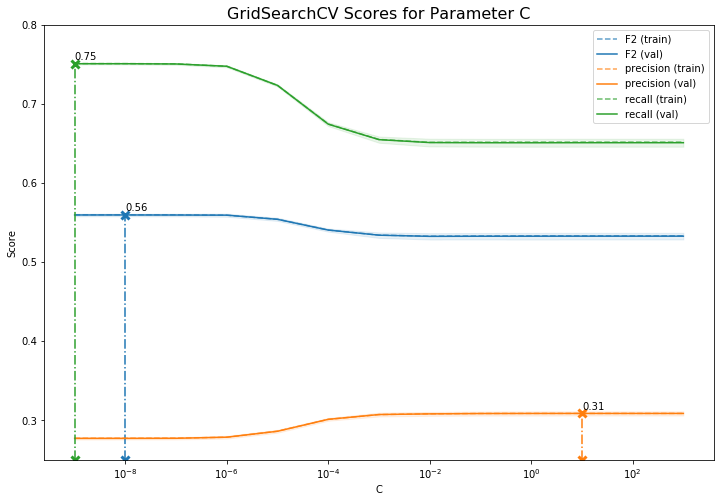

In [84]:
my_func.plot_gs_param(lr_c_gs, set_xscale='log', ylim=(0.25, 0.8), figsize=(12,8))

C values below 1e-2 are where we start seeing improvements to recall (and F2) scores.

In [85]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision'}

param_grid = {'C': np.logspace(-9,3,13),
              'penalty': ['l1','l2']}

lr_gs = GridSearchCV(estimator=LogisticRegression(class_weight='balanced'),
                  param_grid = param_grid,
                  scoring=scoring,
                  cv=3,
                  refit=False,
                  n_jobs=4)

my_func.run_time(reset=True)
lr_gs.fit(X_train_rfe, y_train)
my_func.run_time()

Time: 36.67s 


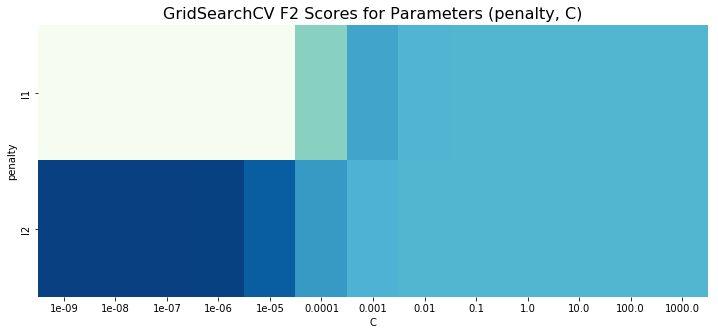

In [226]:
my_func.plot_gs_param_dual(lr_gs, scoring='F2', power_scale=10, cmap='GnBu', swap_axes=True, figsize=(12,5), cbar=False)

L2 penalty clearly performs better than L1, again with lower C values in the 1e-6 to 1e-9 range performing best. Our optimal parameters are as follows:

In [218]:
my_func.gs_score_summary(lr_gs)

--------------------
Best F2:
Params: {'C': 1e-08, 'penalty': 'l2'}
F2 = 0.5599001563244634
Recall = 0.7511935110855013
Precision = 0.2773717129399583
--------------------
Best Recall:
Params: {'C': 1.0000000000000001e-09, 'penalty': 'l2'}
F2 = 0.5598859520292723
Recall = 0.7511935110855013
Precision = 0.2773543200374286
--------------------
Best Precision:
Params: {'C': 10.0, 'penalty': 'l2'}
F2 = 0.5330910193088749
Recall = 0.6512787156720699
Precision = 0.3088824298843297
--------------------


Our best F2 result is with C = 1e-8 and L2 penalty.

Note that these optimizations are all with balanced class weights, as it was already established that no balancing yields unacceptable recall scores.

Testing this model on the full training validation sets:

In [233]:
lr_best = LogisticRegression(C=1e-8, class_weight='balanced', penalty='l2')

my_func.run_time(reset=True)
lr_best.fit(X_train_rfe, y_train)
my_func.run_time()

Time: 128ms 


Fit time has been drastically improved with the addition of regularization.

In [229]:
y_train_pred = lr_best.predict(X_train_rfe)
y_val_pred = lr_best.predict(X_val_rfe)

In [232]:
lr_best_cvs = cross_val_score(lr_best, X_train_rfe, y_train, scoring=f2_score)
my_func.print_cvs(lr_best_cvs, 'f2')

Mean f2 score = 0.560 (+/- 0.002)


In [230]:
lr_train_summary = my_func.classifier_summary(y_train, y_train_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               52437               45877
Actual Positive                5833               17627
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.560142
Recall           0.751364
Precision (pos)  0.277573
Precision (neg)  0.899897
Specificity      0.533362


In [231]:
lr_val_summary = my_func.classifier_summary(y_val, y_val_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               13178               11452
Actual Positive                1462                4352
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.557092
Recall           0.748538
Precision (pos)  0.275373
Precision (neg)  0.900137
Specificity      0.535039


We have managed to boost our recall to 0.74-0.75 whilst still maintaining a precision above 0.25 and specificity above 0.5, still statisfying our initial goal criteria. It is worth noting that our regularization parameter C is rather extreme with a value of 1e-8, so if we sought to improve precision/specificity for a sligtly reduced recall (i.e. 0.7), choosing a higher value  with more of a compromised recall & precision score (i.e. around the 1e-4 range based off the initial C plot) would be an alternative option.

### PCA

As determined during data preparation, reducing dimensionality via PCA can still retain over 99% of variance whilst signficantly reducing the number of components. Whilst we have already reduced the number of features used via RFE for the optimized model above, we will try this alternative approach with PCA to see if any improvements can be made. We will attempt to find the optimal amount of dimensionality reduction by performing grid search with various variance thresholds:

In [238]:
pca_pipe = Pipeline([('pca', PCA()),
                     ('estimator', LogisticRegression(class_weight='balanced', penalty='l2'))])

scoring = {'F2': f2_score}

param_grid = {'estimator__C': np.logspace(-9,3,13),
              'pca__n_components': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999, None]}

lr_pca_gs = GridSearchCV(estimator=pca_pipe,
                  param_grid = param_grid,
                  scoring=scoring,
                  cv=3,
                  refit=False,
                  n_jobs=4)

my_func.run_time(reset=True)
lr_pca_gs.fit(X_train, y_train);
my_func.run_time()

Time: 2min 29s 


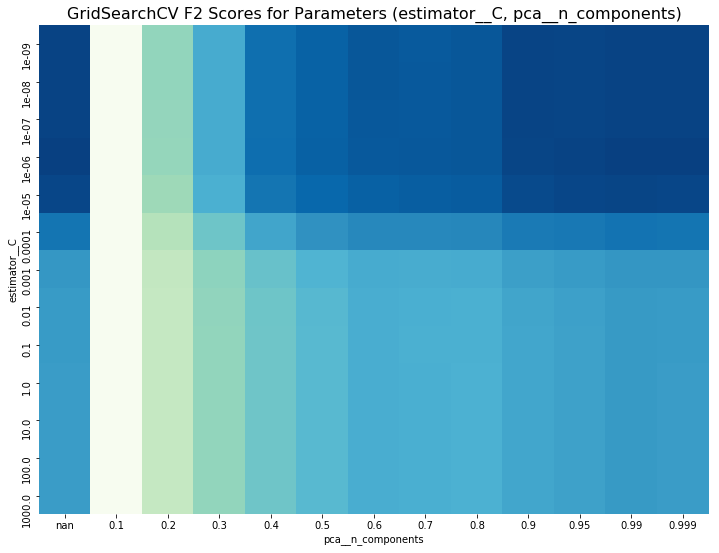

In [244]:
plot_gs_param_dual(lr_pca_gs, scoring='F2', power_scale=10, cbar=False)

Based off the heatmap above, C = 1e-6 with a PCA n_components >= 0.99 (nan = 100%) shows the most promise. Performing a full grid search in these ranges, whilst also checking L1 penalty again for safe measure:

In [248]:
pca_pipe = Pipeline([('pca', PCA()),
                     ('estimator', LogisticRegression())])

scoring = {'F2': f2_score,
           'recall': 'recall',
           'precision': 'precision',
           'specificity': make_scorer(my_func.binary_specificity)}

param_grid = {'estimator__C': np.logspace(-12,-4, 9),
              'estimator__class_weight': ['balanced'],
              'estimator__penalty': ['l1','l2'],
              'pca__n_components': [None, 0.95, 0.96, 0.97, 0.98, 0.99, 0.999, 0.9999]}

pca_gs = GridSearchCV(estimator=pca_pipe,
                  param_grid = param_grid,
                  scoring=scoring,
                  cv=3,
                  refit=False,
                  n_jobs=4)

my_func.run_time(reset=True)
pca_gs.fit(X_train, y_train);
my_func.run_time()

Time: 2min 21s 


In [249]:
my_func.gs_score_summary(pca_gs)

--------------------
Best F2:
Params: {'estimator__C': 9.9999999999999995e-07, 'estimator__class_weight': 'balanced', 'estimator__penalty': 'l2', 'pca__n_components': 0.999}
F2 = 0.5523177896392625
Recall = 0.7260017067800371
Precision = 0.28223961920132634
Specificity = 0.5594218598089986
--------------------
Best Recall:
Params: {'estimator__C': 1e-08, 'estimator__class_weight': 'balanced', 'estimator__penalty': 'l2', 'pca__n_components': 0.99}
F2 = 0.5518580507903212
Recall = 0.7264705903355329
Precision = 0.28135773697841326
Specificity = 0.5572146454497865
--------------------
Best Precision:
Params: {'estimator__C': 0.0001, 'estimator__class_weight': 'balanced', 'estimator__penalty': 'l2', 'pca__n_components': None}
F2 = 0.5425537231582839
Recall = 0.681287252722613
Precision = 0.29900717988929204
Specificity = 0.6188538830570468
--------------------
Best Specificity:
Params: {'estimator__C': 9.9999999999999998e-13, 'estimator__class_weight': 'balanced', 'estimator__penalty': 'l1

Selecting a number of components accounting for 99.9% of variance yields our best F2 and recall scores.

In [251]:
lr_pca = Pipeline([('pca', PCA(n_components=0.999)),
                   ('estimator', LogisticRegression(class_weight='balanced', C=1e-6, penalty='l2'))])

lr_pca.fit(X_train, y_train);

In [252]:
lr_pca.named_steps['pca'].n_components_, lr_pca.named_steps['pca'].n_features_

(36, 44)

We can see even with 99.9% of variance accounted for, we have still managed to reduce the number of features/components from 44 to 36.

In [253]:
pca_cvs = cross_val_score(lr_pca, X_train, y_train, scoring=f2_score)

my_func.print_cvs(pca_cvs, 'f2')

Mean f2 score = 0.552 (+/- 0.001)


In [254]:
my_func.classifier_summary(y_train, lr_pca.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               55089               43225
Actual Positive                6438               17022
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.552350
Recall           0.725575
Precision (pos)  0.282537
Precision (neg)  0.895363
Specificity      0.560337


In [255]:
my_func.classifier_summary(y_val, lr_pca.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               13785               10845
Actual Positive                1588                4226
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.551308
Recall           0.726866
Precision (pos)  0.280406
Precision (neg)  0.896702
Specificity      0.559683


Compared to our first approach with RFE, our recall is not quite as high with 0.72 versus 0.75. However, we can see this approach does slightly benefit precision and specificity over RFE with increases on the magnitude of 0.01-0.02.

Perhaps PCA can show improvements in tandem with our RFE feature set:

In [256]:
pca_pipe = Pipeline([('pca', PCA()),
                     ('estimator', LogisticRegression())])

scoring = {'F2': f2_score,
           'recall': 'recall',
           'precision': 'precision',
           'specificity': make_scorer(my_func.binary_specificity)}

param_grid = {'estimator__C': np.logspace(-12,-4, 9),
              'estimator__class_weight': ['balanced'],
              'estimator__penalty': ['l1','l2'],
              'pca__n_components': [None, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 0.999, 0.9999]}

rfe_pca_gs = GridSearchCV(estimator=pca_pipe,
                  param_grid = param_grid,
                  scoring=scoring,
                  cv=3,
                  refit=False,
                  n_jobs=4)

my_func.run_time(reset=True)
rfe_pca_gs.fit(X_train_rfe, y_train);
my_func.run_time()

Time: 2min 276ms 


In [257]:
my_func.gs_score_summary(rfe_pca_gs)

--------------------
Best F2:
Params: {'estimator__C': 1e-08, 'estimator__class_weight': 'balanced', 'estimator__penalty': 'l2', 'pca__n_components': None}
F2 = 0.5552485329646331
Recall = 0.7293265191646577
Precision = 0.2840604893671982
Specificity = 0.5613442745432273
--------------------
Best Recall:
Params: {'estimator__C': 1e-08, 'estimator__class_weight': 'balanced', 'estimator__penalty': 'l2', 'pca__n_components': None}
F2 = 0.5552485329646331
Recall = 0.7293265191646577
Precision = 0.2840604893671982
Specificity = 0.5613442745432273
--------------------
Best Precision:
Params: {'estimator__C': 0.0001, 'estimator__class_weight': 'balanced', 'estimator__penalty': 'l2', 'pca__n_components': None}
F2 = 0.5433252148226483
Recall = 0.681756158330616
Precision = 0.2998182853084457
Specificity = 0.6200642892514274
--------------------
Best Specificity:
Params: {'estimator__C': 9.9999999999999998e-13, 'estimator__class_weight': 'balanced', 'estimator__penalty': 'l1', 'pca__n_components

PCA is not able to enhance our results beyond the feature reduction acheived via RFE, since our best PCA results occur when all features are selected.

### Decision Threshold & PR Curve

..\src\functions\my_functions.py:337: RuntimeWarning: invalid value encountered in true_divide
  f_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls)


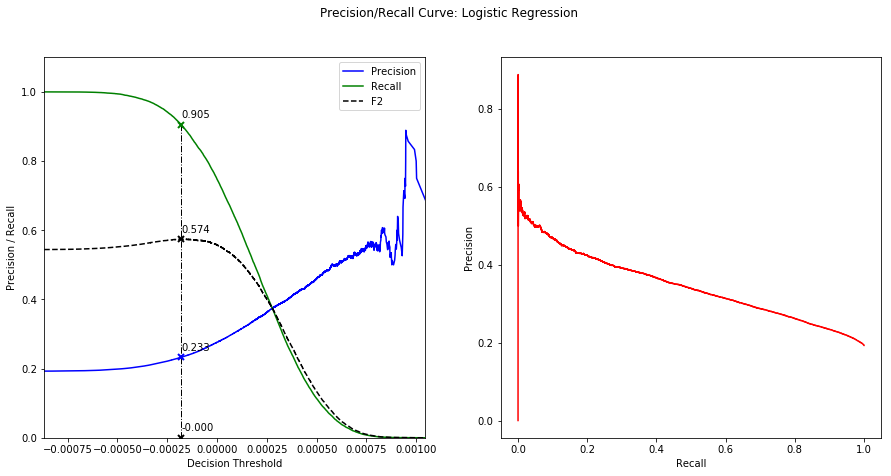

In [259]:
precisions, recalls, thresholds = my_func.plot_pr_curve(lr_best, X_train, y_train, f_score=True, beta=2, label='Logistic Regression')

By modifying the threshold we can potentially acheive a recall score of 0.9, however this would push our precision below the target minimum of 0.25. A slightly higher threshold (i.e. closer to 0) may provide a better balance:

In [260]:
# Get threshold value for desired recall
desired_recall = 0.9
i = len(recalls) - np.argmax(recalls[::-1] >= desired_recall) - 1
t = thresholds[i]
print('Threshold for Recall = {}: {}'.format(desired_recall, t))

Threshold for Recall = 0.9: -0.00017265042534989153


In [275]:
t_custom = -0.00003

In [276]:
# Filter results based off new threshold
y_train_pred_t = lr_best.decision_function(X_train_rfe) > t_custom
y_val_pred_t = lr_best.decision_function(X_val_rfe) > t_custom

In [277]:
my_func.classifier_summary(y_train, y_train_pred_t);

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               49431               48883
Actual Positive                5262               18198
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.565433
Recall           0.775703
Precision (pos)  0.271284
Precision (neg)  0.903790
Specificity      0.502787


In [278]:
my_func.classifier_summary(y_val, y_val_pred_t);

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               12395               12235
Actual Positive                1315                4499
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.562516
Recall           0.773822
Precision (pos)  0.268854
Precision (neg)  0.904085
Specificity      0.503248


With a threshold of -0.00003, we are able to push recall to 0.77, but it results in specificity coming very close to our minimum of 0.5 meaning practically half of our non-default loans are being discarded as false positives.

### Polynomial Features

Polynomial feature prep:

In [7]:
# Columns identified thus far as best for classification (during data prep, select K best)
num_attr = ['funded_amnt_q10', 'int_rate_delta', 'annual_inc_q10', 'dti', 'delinq_2yrs', 'inq_last_6mths',
            'open_acc', 'revol_bal_log', 'revol_util', 'total_acc', 'collections_12_mths_ex_med',
            'acc_now_delinq', 'rev_lim_sqrt', 'tot_cur_bal', 'tot_coll_amt', 'subgrade_p_value',
            'lti', 'rbti', 'tbti', 'cr_line_td_log', 'emp_length_val']

bin_attr = ['had_delinq', 'had_major_derog', 'had_record', 'verified', 'term_bin']

cat_attr = ['purpose', 'home_ownership']

In [8]:
num_prep = Pipeline([('custom', my_func.CustomNumAttributes()), # Create custom num attr
                     ('select', my_func.DataFrame_Selector(num_attr)), # Select num columns
                     ('p_quadratic', PolynomialFeatures(degree=2)),
                     ('sc', StandardScaler())]) # Scale data

bin_prep = Pipeline([('custom', my_func.CustomBinAttributes()), # Create custom bin attr
                     ('select', my_func.DataFrame_Selector(bin_attr))]) # Select binary columns

cat_prep = Pipeline([('encode', my_func.DataFrame_DummyEncoder(cat_attr))]) # Select & encode categrocial columns

quadratic_prep = FeatureUnion([('num', num_prep),
                             ('bin', bin_prep),
                             ('cat', cat_prep)])

In [9]:
X_train_quad_full = quadratic_prep.fit_transform(data['train'])

In [10]:
X_test_quad = quadratic_prep.transform(data['test'])

In [11]:
X_train_quad_full.shape, X_test_quad.shape

((152218, 276), (38055, 276))

In [12]:
X_train_quad, X_val_quad, y_train, y_val = train_test_split(X_train_quad_full, y_train_full, test_size=0.2, random_state=42)

##### Base Model

In [23]:
my_func.run_time(reset=True)
lr_quad_basic = LogisticRegression(class_weight='balanced').fit(X_train_quad, y_train)
my_func.run_time()

Time: 3min 4s 


In [130]:
my_func.classifier_summary(y_train, lr_quad_basic.predict(X_train_quad));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               63036               35278
Actual Positive                7537               15923
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.548914
Recall           0.678730
Precision (pos)  0.310990
Precision (neg)  0.893203
Specificity      0.641170


In [131]:
my_func.classifier_summary(y_val, lr_quad_basic.predict(X_val_quad));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               15826                8804
Actual Positive                1863                3951
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.548582
Recall           0.679567
Precision (pos)  0.309761
Precision (neg)  0.894680
Specificity      0.642550


For an untuned model, we are actually seeing slightly better results in recall with quadratic features than our regular set. Given the number of features, however, fit times have increased drastically. One would hope that feature selection would aid in computation times, as well as model performance by eliminating redundant polynomial features.

##### Feature Selection

The amount of time to process through RFE with cross validation etc. is likely to be a very time consuming process. A better comprimise may be to select coefficients past a certain value threshold using SelectFromModel:

Complete                                                                                            


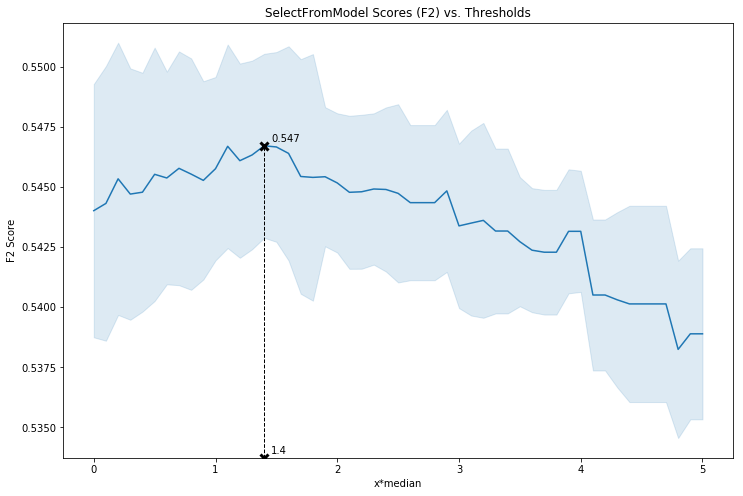

In [123]:
my_func.sfm_scores = plot_sfm(estimator=lr_quad_basic, X=X_train_quad, y=y_train, p_range=np.arange(0.0, 5.1, 0.1), scoring='f2', cv=3, p_ref='median', prefit=True, figsize=(12,8), verbose=True);

In [125]:
lr_quad_sfm = Pipeline([('select', SelectFromModel(LogisticRegression(class_weight='balanced'), threshold='1.4*median')),
                        ('estimator', LogisticRegression(class_weight='balanced'))])

lr_quad_sfm.fit(X_train_quad, y_train)

Pipeline(memory=None,
     steps=[('select', SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, war...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [126]:
sfm_cvs = cross_val_scores_val_score(lr_quad_sfm, X_train_quad, y_train, scoring=f2_score, cv=3)
my_func.print_cvs(sfm_cvs, 'f2')

Mean f2 score = 0.544 (+/- 0.004)


In [133]:
my_func.classifier_summary(y_train, lr_quad_sfm.predict(X_train_quad));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               62725               35589
Actual Positive                7506               15954
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.548689
Recall           0.680051
Precision (pos)  0.309528
Precision (neg)  0.893124
Specificity      0.638007


In [132]:
my_func.classifier_summary(y_val, lr_quad_sfm.predict(X_val_quad));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               15765                8865
Actual Positive                1845                3969
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.549875
Recall           0.682663
Precision (pos)  0.309257
Precision (neg)  0.895230
Specificity      0.640073


Whilst the number of features has been decreased signficantly, we have only managed to achieve a recall score about 0.01 higher than our default model. We will also explore PCA to see if it performs any better:

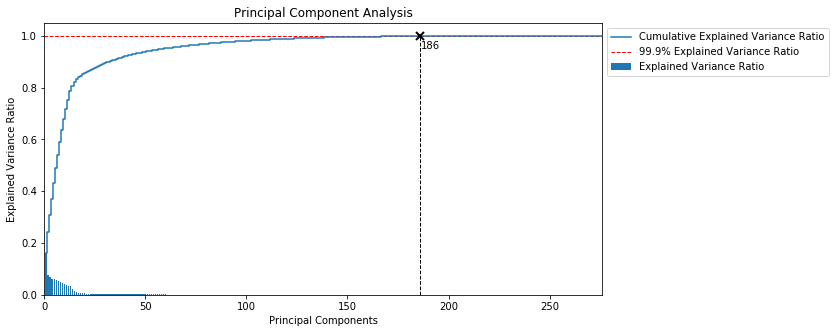

In [332]:
my_func.plot_pca_var(X_train_quad, p=0.999);

As we can see above, we can already capture 99.9% of variance with just 186 of the 276 features. We will explore a range of % variance captured versus model performance via grid search:

In [337]:
pca_pipe = Pipeline([('pca', PCA()),
                     ('estimator', LogisticRegression(class_weight='balanced'))])

scoring = {'F2': f2_score,
           'recall': 'recall',
           'precision': 'precision'}

param_grid = {'pca__n_components': [None, 0.8, 0.9, 0.95, 0.99, 0.999, 0.9999]}

quad_pca_gs = GridSearchCV(estimator=pca_pipe,
                  param_grid = param_grid,
                  scoring=scoring,
                  cv=3,
                  refit=False,
                  n_jobs=4)

my_func.run_time(reset=True)
quad_pca_gs.fit(X_train_quad, y_train);
my_func.run_time()

Time: 3min 53s 


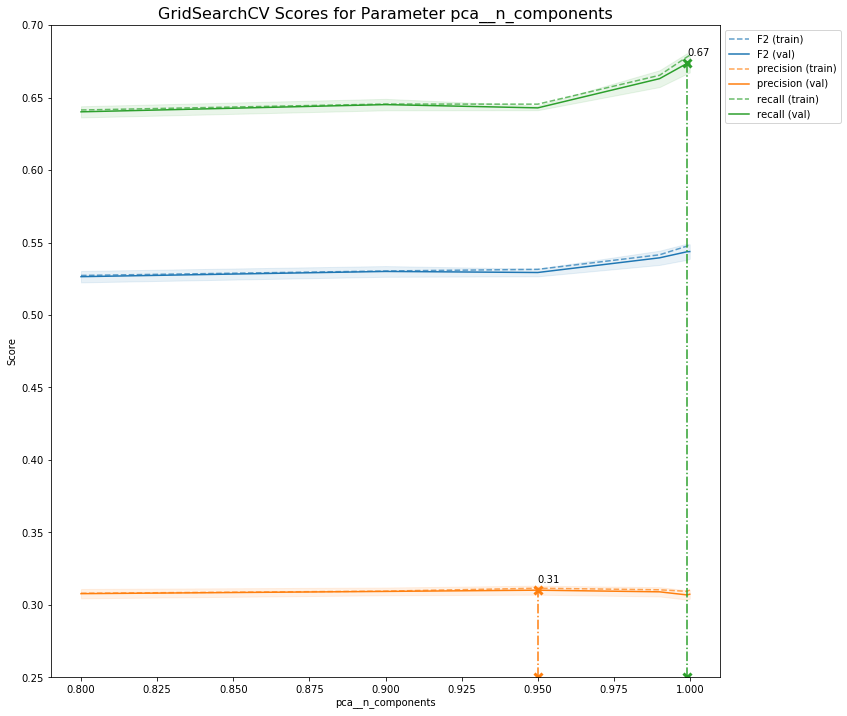

In [338]:
my_func.plot_gs_param(quad_pca_gs, ylim=(0.25,0.7))

In [339]:
my_func.gs_score_summary(quad_pca_gs)

--------------------
Best F2:
Params: {'pca__n_components': None}
F2 = 0.5439685990388861
Recall = 0.6726768292880143
Precision = 0.3081380509238862
--------------------
Best Recall:
Params: {'pca__n_components': 0.999}
F2 = 0.5436278488095333
Recall = 0.6735293298553939
Precision = 0.3068844862853637
--------------------
Best Precision:
Params: {'pca__n_components': 0.95}
F2 = 0.5293150116872055
Recall = 0.6428814832743075
Precision = 0.3101685428619712
--------------------


Unfortunately, our best F2 score is achieved using all features (100% variance). Our best recall, however, utilizes 99.9% so considering the necessity of dimensionality reduction from a computational standpoint we should not have much issue deferring to this value. However, our scores achieved via PCA are still slightly less than the set of features used via the SelectFromModel approach, so we will proceed with optimizing our models in tandem feature selection instead of PCA.

##### Parameter Tuning:

We will start with a basic grid search on a selec few values to establish which may be worth exploring in detail. Note that the SelectFromModel process has been extracted from the pipeline approach to avoid refitting with every grid search iteration.

In [135]:
sfm = SelectFromModel(estimator=lr_quad_basic, prefit=True, threshold='1.4*median')
X_train_quad_sfm = sfm.transform(X_train_quad)
X_val_quad_sfm = sfm.transform(X_val_quad)

In [138]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

param_grid = {'C': np.logspace(-9, 3, 13),
              'penalty': ['l1','l2']}

lr_quad_gs = GridSearchCV(estimator=LogisticRegression(class_weight='balanced'),
                  param_grid = param_grid,
                  scoring=scoring,
                  cv=3,
                  refit=False,
                  n_jobs=4,
                  verbose=3)

my_func.run_time(reset=True)
lr_quad_gs.fit(X_train_quad_sfm, y_train)
my_func.run_time()

Fitting 3 folds for each of 26 candidates, totalling 78 fits


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   25.8s


Time: 33min 51s 


[Parallel(n_jobs=4)]: Done  78 out of  78 | elapsed: 33.8min finished


In [139]:
my_func.gs_score_summary(lr_quad_gs)

--------------------
Best F2:
Params: {'C': 1.0000000000000001e-05, 'penalty': 'l2'}
F2 = 0.5480662448466245
Recall = 0.7048167148930493
Precision = 0.29004971980185307
Specificity = 0.5883190679145126
--------------------
Best Recall:
Params: {'C': 1.0000000000000001e-05, 'penalty': 'l2'}
F2 = 0.5480662448466245
Recall = 0.7048167148930493
Precision = 0.29004971980185307
Specificity = 0.5883190679145126
--------------------
Best Precision:
Params: {'C': 1.0, 'penalty': 'l1'}
F2 = 0.5468011336679379
Recall = 0.677323054148734
Precision = 0.30878727201106004
Specificity = 0.6382000548106805
--------------------
Best Specificity:
Params: {'C': 1.0000000000000001e-09, 'penalty': 'l1'}
F2 = 0.0
Recall = 0.0
Precision = 0.0
Specificity = 1.0
--------------------


Our best F2 & recall scores do not quite reach the same heights as our non-polynomial approach, but we do at least see some improvements over the non-regularized model. We will score this best polynomial with the same procedure for good measure:

In [140]:
lr_quad_best = LogisticRegression(class_weight='balanced', C=1e-5, penalty='l2')

In [141]:
lr_quad_cvs = cross_val_score(lr_quad_best, X_train_quad_sfm, y_train, cv=3, scoring=f2_score)
my_func.print_cvs(lr_quad_cvs, 'f2')

Mean f2 score = 0.548 (+/- 0.001)


In [143]:
lr_quad_best.fit(X_train_quad_sfm, y_train)

LogisticRegression(C=1e-05, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [144]:
my_func.classifier_summary(y_train, lr_quad_best.predict(X_train_quad_sfm));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               58348               39966
Actual Positive                6997               16463
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.547784
Recall           0.701748
Precision (pos)  0.291747
Precision (neg)  0.892922
Specificity      0.593486


In [146]:
my_func.classifier_summary(y_val, lr_quad_best.predict(X_val_quad_sfm));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               14667                9963
Actual Positive                1736                4078
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.546693
Recall           0.701410
Precision (pos)  0.290435
Precision (neg)  0.894166
Specificity      0.595493


Based off the results above, there seems to be little justification in taking a polynomial features approach. We could explore additional degrees of polynomial features, but even quadratic features bloated our computation times, and given the lackluster scores from these polynomial features it is unlikely we will gain much from higher degrees.

### Test Performance

##### OneR Baseline

In [194]:
oner = DecisionTreeClassifier(class_weight='balanced', max_depth=1)
oner.fit(X_train_full, y_train_full);

In [196]:
my_func.classifier_summary(y_train_full, oner.predict(X_train_full));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               73026               49918
Actual Positive               10013               19261
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.517004
Recall           0.657956
Precision (pos)  0.278423
Precision (neg)  0.879418
Specificity      0.593978


In [198]:
my_func.classifier_summary(y_test, oner.predict(X_test));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               18329               12599
Actual Positive                2451                4676
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.510670
Recall           0.656097
Precision (pos)  0.270680
Precision (neg)  0.882050
Specificity      0.592635


##### Basic LR Model

In [173]:
lr_basic = LogisticRegression(class_weight='balanced')
lr_basic.fit(X_train_full, y_train_full);

In [174]:
my_func.classifier_summary(y_train_full, lr_basic.predict(X_train_full));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               80202               42742
Actual Positive               10157               19117
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.534129
Recall           0.653037
Precision (pos)  0.309042
Precision (neg)  0.887593
Specificity      0.652346


In [175]:
my_func.classifier_summary(y_test, lr_basic.predict(X_test));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               20078               10850
Actual Positive                2504                4623
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.525568
Recall           0.648660
Precision (pos)  0.298779
Precision (neg)  0.889115
Specificity      0.649185


##### Tuned Model (RFE)

In [184]:
lr_rfe = Pipeline([('rfe', RFE(estimator=LogisticRegression(class_weight='balanced'), n_features_to_select=28)),
                   ('lr', LogisticRegression(class_weight='balanced', C=1e-8, penalty='l2'))])

lr_rfe.fit(X_train_full, y_train_full);

In [185]:
my_func.classifier_summary(y_train_full, lr_rfe.predict(X_train_full));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               64300               58644
Actual Positive                7037               22237
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.561606
Recall           0.759616
Precision (pos)  0.274935
Precision (neg)  0.901356
Specificity      0.523002


In [186]:
my_func.classifier_summary(y_test, lr_rfe.predict(X_test));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               16104               14824
Actual Positive                1710                5417
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.555601
Recall           0.760067
Precision (pos)  0.267625
Precision (neg)  0.904008
Specificity      0.520693


##### Tuned Model (PCA)

In [181]:
lr_pca = Pipeline([('pca', PCA(n_components=0.999)),
                   ('estimator', LogisticRegression(class_weight='balanced', C=1e-6, penalty='l2'))])

lr_pca.fit(X_train_full, y_train_full);

In [182]:
my_func.classifier_summary(y_train_full, lr_pca.predict(X_train_full));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               68853               54091
Actual Positive                8008               21266
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.552499
Recall           0.726447
Precision (pos)  0.282203
Precision (neg)  0.895812
Specificity      0.560035


In [188]:
my_func.classifier_summary(y_test, lr_pca.predict(X_test));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               17208               13720
Actual Positive                1980                5147
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.543219
Recall           0.722183
Precision (pos)  0.272804
Precision (neg)  0.896811
Specificity      0.556389


##### Polynomial (Quadratic) Model

In [190]:
lr_quad = Pipeline([('select', SelectFromModel(estimator=LogisticRegression(class_weight='balanced'), threshold='1.4*median')),
                    ('estimator', LogisticRegression(class_weight='balanced', C=1e-5, penalty='l2'))])

# Note the use of polynomial feature sets, which were transformed earlier
lr_quad.fit(X_train_quad_full, y_train_full)

Pipeline(memory=None,
     steps=[('select', SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, war...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [191]:
my_func.classifier_summaryfier_summary(y_train_full, lr_quad.predict(X_train_quad_full));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               73041               49903
Actual Positive                8705               20569
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.548308
Recall           0.702637
Precision (pos)  0.291875
Precision (neg)  0.893512
Specificity      0.594100


In [192]:
my_func.classifier_summary(y_test, lr_quad.predict(X_test_quaduad));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               18307               12621
Actual Positive                2119                5008
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.542731
Recall           0.702680
Precision (pos)  0.284077
Precision (neg)  0.896260
Specificity      0.591923


##### Ranking

1. Tuned Model (RFE)
2. Tuned Model (PCA)
3. Quadratic Model
4. Basic LR Model
5. OneR Baseline